### Imports

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision.datasets import MNIST
from PIL import Image
import random
import imutils
from torchvision.utils import save_image
import cv2
from torch.autograd import Variable


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
    ])
batch_size = 100
learning_rate = 0.1

def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

### TrainSet1

In [ ]:
colors_dict = {}
colors_dict[0]= (203, 215, 214) #grey
colors_dict[1]= (209, 84, 69) #red
colors_dict[2]= (201, 235, 52) #yellow
colors_dict[3]= (8, 218, 83) #green
colors_dict[4]= (222, 55, 216) #pink
colors_dict[5]= (83, 52, 235) # blue
colors_dict[6]= (174, 52, 235) #purple
colors_dict[7]= (33, 228, 235) #light blue
colors_dict[8]= (79, 67, 66) #brown
colors_dict[9]= (240, 172, 14) # orange

In [ ]:
class Change_Color(MNIST):
  def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
    super(Change_Color, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)

  def __getitem__(self,index ):
    image, label = self.data[index], self.targets[index]
    image_np =  image.numpy()
    black_indicator = 0

    #Resize the vector to fit RGB
    rgb_img = cv2.cvtColor(image_np,cv2.COLOR_GRAY2RGB)
    #Generate random color
    int_label = int(label)
    nd_color = colors_dict[int_label]

    rgb_img =  np.where(rgb_img>black_indicator, nd_color, rgb_img).astype(np.uint8)
    image_np= Image.fromarray(rgb_img)

    if self.transform is not None:
        final_image = self.transform(rgb_img)
    if self.target_transform is not None:
        label = self.target_transform(label)


    return final_image, label

In [ ]:
transform = transforms.ToTensor()
train_dataset = Change_Color(root='./data', train=True, download=True, transform=transform)

In [ ]:
#upload the colored dataset :)
for i in range(len(train_dataset)):
    train_dataset.__getitem__(i)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle = True)

### TrainSet2

create another train set, but each digit is colored with different color from train set1

In [ ]:
colors_dict2 = {}
colors_dict2[0]= (240, 172, 14)# orange
colors_dict2[1]= (174, 52, 235) #purple
colors_dict2[2] = (33, 228, 235) #light blue
colors_dict2[3] = (201, 235, 52) #yellow
colors_dict2[4] = (203, 215, 214) #grey
colors_dict2[5]= (209, 84, 69) #red
colors_dict2[6]= (83, 52, 235) # blue
colors_dict2[7]=(79, 67, 66) #brown
colors_dict2[8]= (8, 218, 83) #green
colors_dict2[9]= (222, 55, 216) #pink

In [ ]:
class Change_Color2(MNIST):
  def __init__(self, root, train=True, download=False, transform=False, target_transform= None):
    super(Change_Color2, self).__init__(root, train=train, download=download, transform=transform, target_transform =target_transform)

  def __getitem__(self,index ):
    image, label = self.data[index], self.targets[index]
    image_np =  image.numpy()
    black_indicator = 0

    #Resize the vector to fit RGB
    rgb_img = cv2.cvtColor(image_np,cv2.COLOR_GRAY2RGB)
    #Generate random color
    int_label = int(label)
    nd_color = colors_dict2[int_label]

    rgb_img =  np.where(rgb_img>black_indicator, nd_color, rgb_img).astype(np.uint8)
    image_np= Image.fromarray(rgb_img)

    if self.transform is not None:
        final_image = self.transform(rgb_img)
    if self.target_transform is not None:
        label = self.target_transform(label)


    return final_image, label

In [ ]:
transform = transforms.ToTensor()
train_dataset2 = Change_Color2(root='./data', train=True, download=True, transform=transform)

In [ ]:
#upload the colored dataset :)
for i in range(len(train_dataset2)):
    train_dataset2.__getitem__(i)

In [ ]:
data_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, batch_size=100, shuffle = True)

### Cycle GAN

In [ ]:
class G12(nn.Module):
    """Generator for transfering from mnist1  to mnist2"""
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        self.layer1 = nn.Conv2d(3, 12, 3, stride = 1, padding = 1)
        self.layer2 = nn.Conv2d(12, 64, 2, stride = 1, padding = 1)
        self.layer3 = nn.Conv2d(64, 3, 4, stride = 1, padding = 1)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [ ]:
class G21(nn.Module):
    """Generator for transfering from mnist2 to mnist1"""
    def __init__(self):
        super(G21, self).__init__()
        self.layer1 = nn.Conv2d(3, 12, 3, stride = 1, padding = 1)
        self.layer2 = nn.Conv2d(12, 64, 2, stride = 1, padding = 1)
        self.layer3 = nn.Conv2d(64, 3, 4, stride = 1, padding = 1)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = self.layer3(out)
        return out

In [ ]:
class D1(nn.Module):
    """Discriminator for mnist1."""
    def __init__(self):
        super(D1, self).__init__()
        self.layer1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(12, 64, 3, stride=1, padding=1)
        self.lin1 = nn.Linear(3136, 128)
        self.lin2 = nn.Linear(128, 1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(F.relu(self.layer1(x)))
        out = self.pool(F.relu(self.layer2(out)))
        out = out.view(-1, 3136)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
class D2(nn.Module):
    """Discriminator for mnist2."""
    def __init__(self):
        super(D2, self).__init__()
        self.layer1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)
        self.layer2 = nn.Conv2d(12, 64, 3, stride=1, padding=1)
        self.lin1 = nn.Linear(3136, 128)
        self.lin2 = nn.Linear(128, 1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.pool(F.relu(self.layer1(x)))
        out = self.pool(F.relu(self.layer2(out)))
        out = out.view(-1, 3136)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
g12 = G12()
g21 = G21()
d1 = D1()
d2 = D2()

lr = 0.001

d1_optimizer = torch.optim.Adam(d1.parameters(), lr)
d2_optimizer = torch.optim.Adam(d2.parameters(), lr)
g12_optimizer = torch.optim.Adam(g12.parameters(), lr)
g21_optimizer = torch.optim.Adam(g21.parameters(), lr)

criterion = nn.BCELoss()

In [ ]:
def create_images(mnist1, mnist2, g12, g21, epoch):
    g12.eval()
    g21.eval()

    mnist2_fake = g12(mnist1)
    mnist1_fake = g21(mnist2)

    m1_images = torch.zeros((10 * 2, 3, mnist1.shape[2], mnist1.shape[3]))
    m2_images = torch.zeros((10 * 2, 3, mnist2.shape[2], mnist2.shape[3]))

    even_idx = torch.arange(start=0, end=20, step=2)
    odd_idx = torch.arange(start=1, end=20, step=2)

    m1_images[even_idx] = mnist1[:10].cpu()
    m1_images[odd_idx] = mnist2_fake[:10].cpu()
    m2_images[even_idx] = mnist2[:10].cpu()
    m2_images[odd_idx] = mnist1_fake[:10].cpu()

    rows = 2
    fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,8))
    fig.subplots_adjust(wspace=0)
    ax1.set_title("Real mnist2 --> Fake mnist2", fontsize = 16)
    ax2.set_title("Real mnist1 --> Fake mnist1", fontsize = 16)

    a_imgs_ = torchvision.utils.make_grid(m1_images, nrow=rows).permute(1,2,0).numpy()*255
    a_imgs_ = a_imgs_.astype(np.uint8)
    ax1.imshow(Image.fromarray(a_imgs_))
    ax1.set_xticks([])
    ax1.set_yticks([])

    b_imgs_ = torchvision.utils.make_grid(m2_images, nrow=rows).permute(1,2,0).numpy()*255
    b_imgs_ = b_imgs_.astype(np.uint8)
    ax2.imshow(Image.fromarray(b_imgs_))
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.show()

In [ ]:
mnist1_const, _ = next(iter(data_loader))
mnist2_const, _ = next(iter(data_loader2))
mnist1_const = mnist1_const.to(device)
mnist2_const = mnist2_const.to(device)

In [ ]:
def train(num_epochs, mnist1_loader, mnist2_loader):
  for epoch in range(num_epochs):
        print(f'epoch: {epoch}')

        gen12_loss = 0.0
        gen21_loss = 0.0
        dis1_loss = 0.0
        dis2_loss = 0.0

        for i, (mnist1, mnist2) in enumerate(zip(mnist1_loader, mnist2_loader)):

          img1_real= mnist1[0]
          img2_real = mnist2[0]
          batch_size = img1_real.size(0)


          fake_labels = torch.zeros(batch_size).to(device)
          valid_labels = torch.ones(batch_size).to(device)

          #============ train D1 ============#
          d1.train()
          g21.train(False)

          # train with real images

          img1_out_real = d1(img1_real)

          d1_loss_real = criterion(img1_out_real.squeeze(1),valid_labels)

          # train with fake images
          fake_mnist1 = g21(img2_real)
          img1_fake = d1(fake_mnist1)
          d1_loss_fake = criterion(img1_fake.squeeze(1), fake_labels)

          d1_total_loss = d1_loss_real + d1_loss_fake
          d1.zero_grad()

          dis1_loss += d1_total_loss.item()
          d1_total_loss.backward()
          d1_optimizer.step()

          #============ train G21 ============#
          g21.train()
          d1.train(False)

          fake_mnist1 = g21(img2_real)
          img1_fake = d1(fake_mnist1)
          g21_loss_current = criterion (img1_fake.squeeze(1), valid_labels)
          gen21_loss +=g21_loss_current

          d1.zero_grad()
          g21.zero_grad()
          g21_loss_current.backward()
          g21_optimizer.step()

          #============ train D2 ============#

          d2.train()
          g21.train(False)
          g12.train(False)

          # train with real images

          img2_out_real = d2(img2_real)
          d2_loss_real = criterion(img2_out_real.squeeze(1),valid_labels)

          # train with fake images
          fake_mnist2 = g12(img1_real)
          img2_fake = d2(fake_mnist2)
          d2_loss_fake = criterion(img2_fake.squeeze(1), fake_labels)

          d2_total_loss = d2_loss_real + d2_loss_fake
          d2.zero_grad()

          dis2_loss += d2_total_loss.item()
          d2_total_loss.backward()
          d2_optimizer.step()

          #============ train G12 ============#
          g12.train()
          d2.train(False)

          fake_mnist2 = g12(img1_real)
          img2_fake = d2(fake_mnist2)
          g12_loss_current = criterion (img2_fake.squeeze(1), valid_labels)
          gen12_loss +=g12_loss_current

          d2.zero_grad()
          g12.zero_grad()
          g12_loss_current.backward()
          g12_optimizer.step()

        create_images(mnist1_const, mnist2_const, g12, g21, epoch)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14


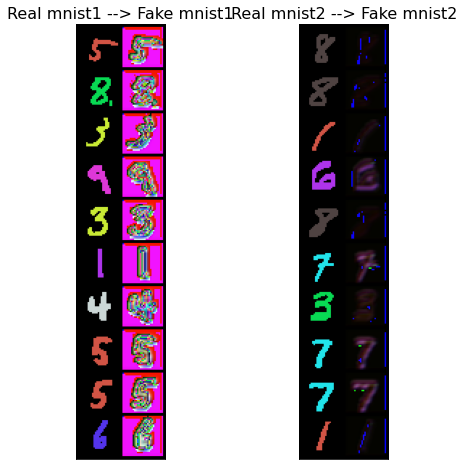

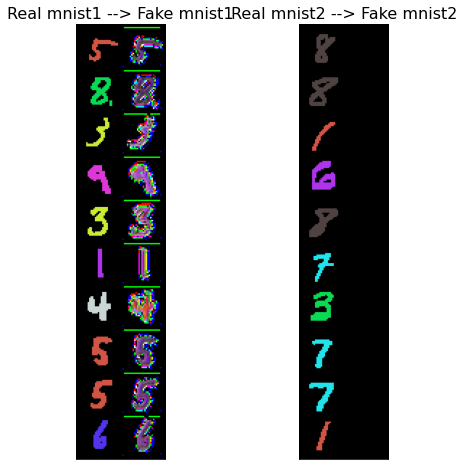

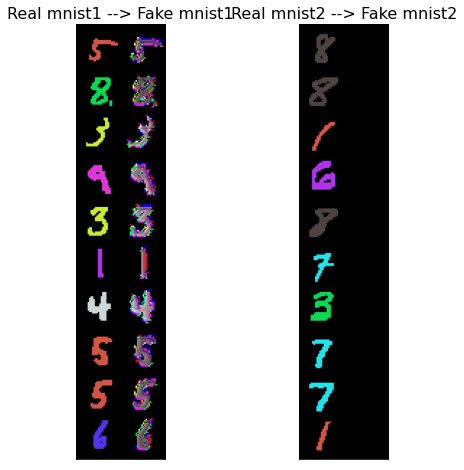

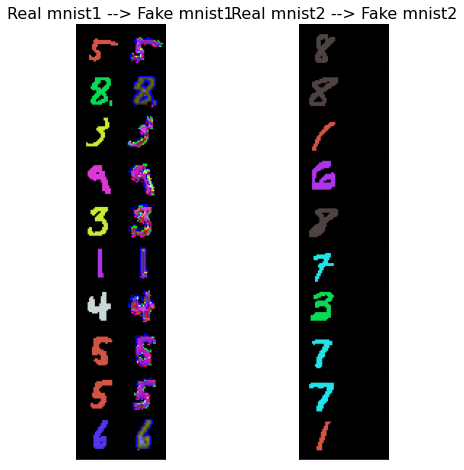

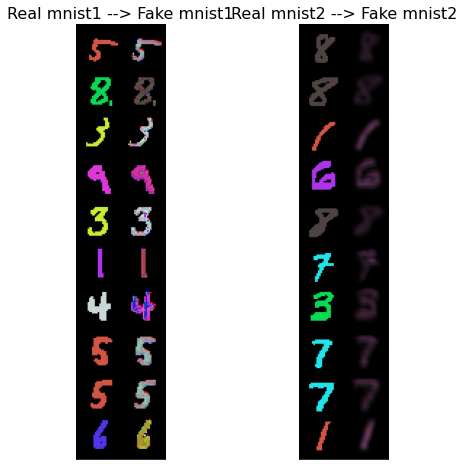

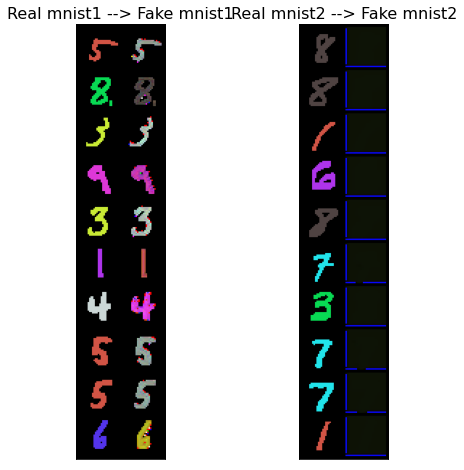

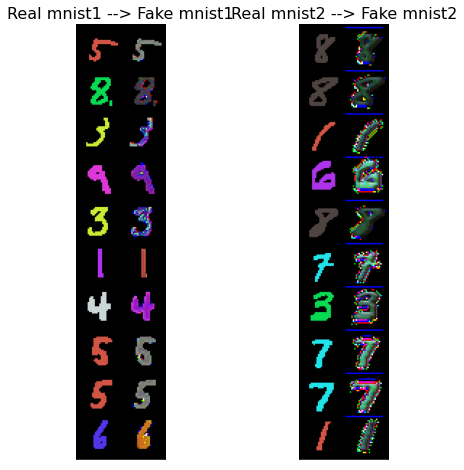

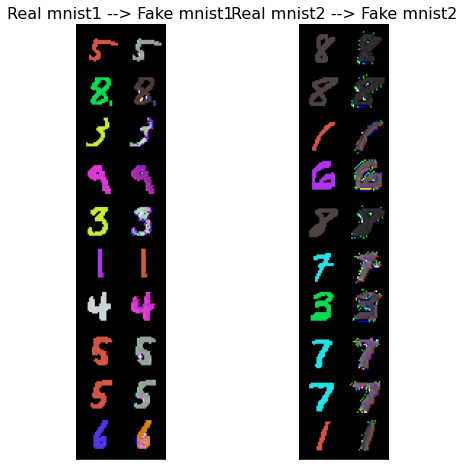

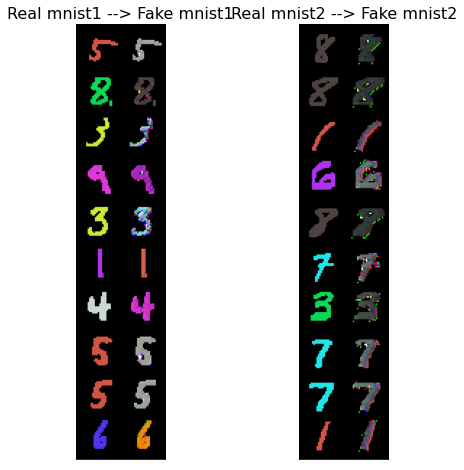

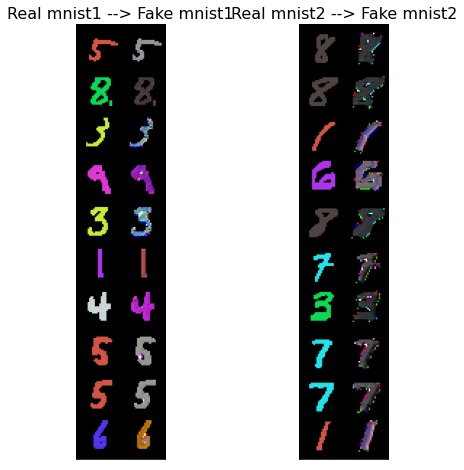

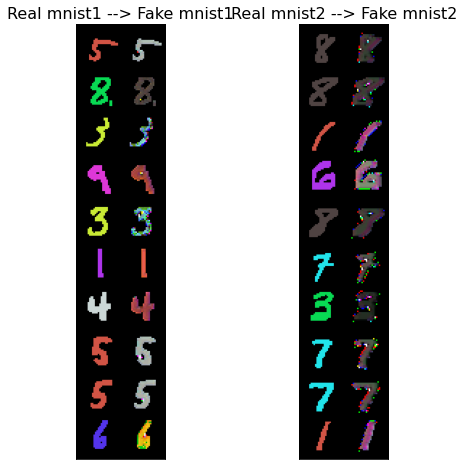

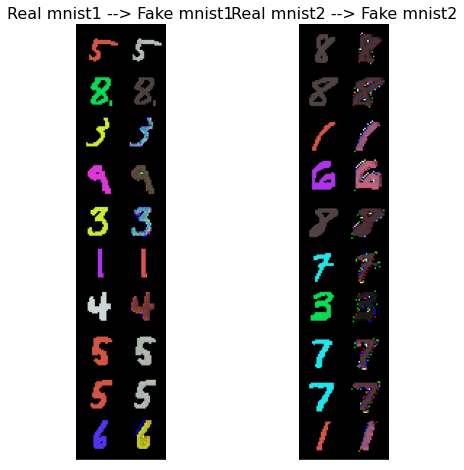

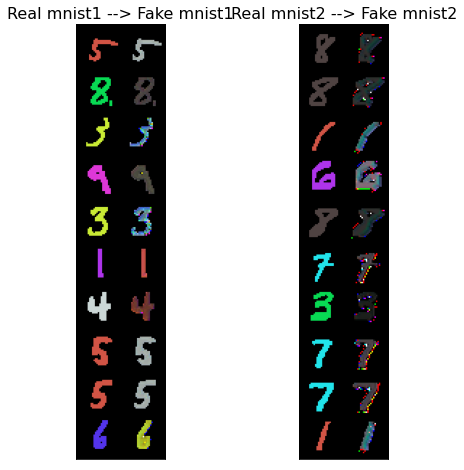

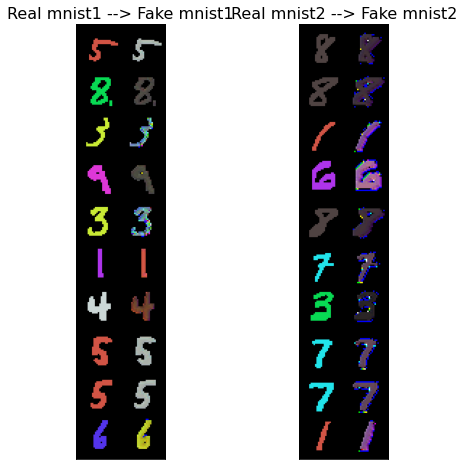

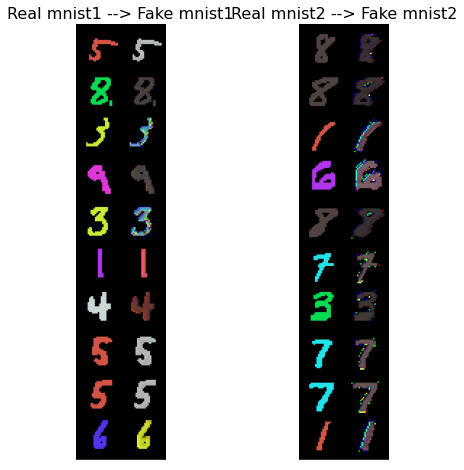

In [ ]:
train(15, data_loader, data_loader2)

In [ ]:
torch.save(g12.state_dict(), 'generator12_206238891_q2.pkl')
torch.save(g21.state_dict(), 'generator21_206238891_q2.pkl')
torch.save(d1.state_dict(), 'discriminator1_206238891_q2.pkl')
torch.save(d2.state_dict(), 'discriminator2_206238891_q2.pkl')